In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr,shapiro,f_oneway, ranksums
from scipy.special import stdtr
import csv
import pandas as pd

from scipy.integrate import quad
import sys 
import os
#sys.path.append(os.path.abspath("/Users/neuroimaging/Desktop/MR-code/Python_Code"))

#from ML_UsefulFunctions import *
#from KidneyROIAnalyses import *

from scipy import special

from scipy.integrate import tplquad

pd.options.display.float_format = '{:.3f}'.format


from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.simplefilter("ignore")


from EllipsoidalSimulationCode import *

from statistics import mean

# Esimation of FA
FA seems to be from about 0.1 to .4

conventional FA (0.19 ± 0.02 and 0.40 ± 0.02) 

https://pubmed.ncbi.nlm.nih.gov/31243814/


combined IVIm and DTI for directionality

https://pubmed.ncbi.nlm.nih.gov/24752998/ Table 2!

## in tissue component:

FA D_tissue cortex = 0.18, medullar = 0.38


## in perfusion component:
FA D_perfusion cortex = 0.09, medullar = 0.41

## in tubular component
guess: tubular would be in between?


# To Do: 

- [x] So given an FA, be able to write up an ellipsoid that has that FA. 

- [x] Assume a tri-component model, give those three components three different FAs

- [x] Build the tri-exponential model (i.e. fraction and TRACE diffusion coefficient)

- [x] Trace is average of the three assumed orthogonal vectors. 

- [x] so for ax, by, cz as the ellipsoid coefficients.... (aDx + bDy + cDz)/3 = D_tr. 

- [x] Think can just be scaling by the radius of a direction... 

- [x] Then for every individual b-value (b_n), rotate ellipsoid and selected the D that would be measured along that direction. 

- [x] Assign that D_n to the given b_n. 

- [x] Plot D_n as a function of b_n 

fit the curve, and see how close it is to true tri-exponential.

# Creating triexp model following Gladytz model

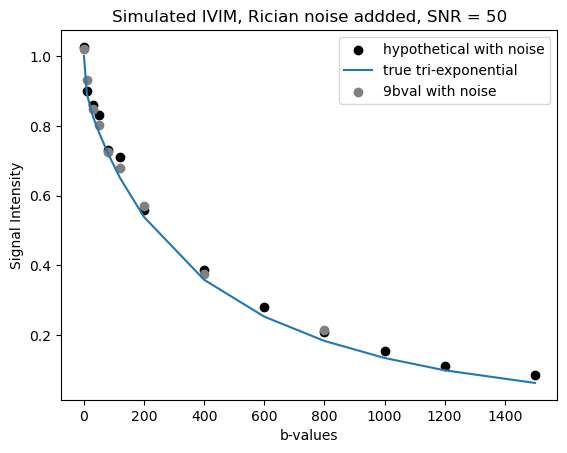

In [18]:
#Diffusion Parameters (Baseline)
diff_fast   = 0.180
diff_med    = 0.0058 #[0.006 0.007 0.008 0.009 0.010];
diff_slow   = 0.0015
frac_fast   = 0.10
frac_med    = 0.30
frac_slow   = 0.60

#hypothetical for the moment
b_values9 = np.array([0,10,30,50,80,120,200,400,800])
b_values = np.array([0,10,30,50,80,120,200,400,600,800,1000,1200, 1500]) # just large range 13 b values 0 - 1500

b_values11 = np.array([0,10,30,50,80,120,200,400,800, 1100, 1380]) # medium range 11 b values 0 - 1380
 
SI = triexp_func(b_values,frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow)
SI_9  = triexp_func(b_values9,frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow)
## can also add noise eventually, but not right now?
# or try adding rician from old code

SI_noise = NoiseRice(SI, .02) # with SNR = 50

SI_noise9 = NoiseRice(SI_9, .02) # with SNR = 50

pl.scatter(b_values,SI_noise,color = 'black', label = 'hypothetical with noise')
pl.plot(b_values,SI,label = 'true tri-exponential')
pl.title('Simulated IVIM, Rician noise addded, SNR = 50')
pl.xlabel('b-values')
pl.ylabel('Signal Intensity')

pl.scatter(b_values9,SI_noise9,color = 'gray', label = '9bval with noise')
pl.legend()
pl.show()

# Calculation of effect of measuring only one direction
So this is 13 b-values 

say the first 6 are fast component (up to 120)

the next four are mid component (up to 600)

the last three are slow component (800 to 1500)

- first six get 6 different directions of rotation 
- next four get 4 different directions of rotation 
- last 3 get three different directions

so now from each individual point, I need to add or subtract the difference that using one direction randomly chosen would give.

for example, for b = 100, the point is $frac_{fast}e^{(-100*D_tr)}$
I need to make it now $frac_{fast}exp{(-100*D_{\theta_1})}$ where $rot1$ is one direction rotated by some angle. I need to calculate $D_{\theta_n}$ for every $b_n$.

With the ellipsoid, essentially Eq. 1
$$D_{tr} =  \frac{(Dxx +Dyy + Dzz)}{3} = \frac{A_xD + B_yD + C_zD}{3}$$

Where $A_x$, $B_y$, and $C_z$ are the scaled ellipsoid eigenvectors.

So, for a given $\theta_n$, we know $D_{tr} = D_{fast}$ (or slow or med). We know the assumed fractional anisotropy, i.e. $A_x$, $B_y$, and $C_z$. Therefore we solve for D in Eq. 1 and we get $D_{\theta_n}$ by rotating the ellipsoid by $\theta_n$, measuring the x-axis in the rotated frame $x_\theta$ (assumed for this, can choose any of the 3 as long as it's consistent across all $\theta_n$s), and then multiplying by D. This $x_{\theta}D = D_{\theta_n}$


In [19]:
# set the 3 ellipsoids

#  the fast component, estimate FA ~ .09
#  the middle component, estimate FA ~ .12
#  the slow component, estimate FA ~ .18

est_FAS = [.09,.12,.18] #true fractional anisotropy
#est_FAS = [0.0,0.1,0.1] #true fractional anisotropy, proof it is all due to FA... 
D_traces = [diff_fast,diff_med, diff_slow] #true D coefficients


# assume 3 random sets of orientations for fast, middle, and slow compartments
fast_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
med_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
slow_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)

assumed_rots = [fast_rot, med_rot, slow_rot]
#print(assumed_rots)
#b0 is D_tr (no directionality) 

# have 12 b values, (13 w b0) so need 12 different rotations.
n = 12
thetax = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)
thetay = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)
thetaz = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)

# generate the 3 ellipsoids: 
fast_compartment, med_compartment, slow_compartment = CreateThreeEllipsoidalCompartments(est_FAS,assumed_rots)

D_fasts = []
D_meds = []
D_slows = []
D_fasts_av = []
D_meds_av = []
D_slows_av = []
for i in range(n):
    # for ith rotation i.e. ith b-val
    thetaxyz = [thetax[i],thetay[i],thetaz[i]]
    #print(thetaxyz)
    [D_traces_fast, D_traces_med, D_traces_slow], [D_ave_trace_fast, D_ave_trace_med, D_ave_trace_slow] = GetOrthogonalD_thetas(D_traces,fast_compartment, med_compartment, slow_compartment, thetaxyz)
    
    # single direction only
    D_fasts.append(D_traces_fast)
    D_meds.append(D_traces_med)
    D_slows.append(D_traces_slow)
    
    #average of 3 directions
    D_fasts_av.append(D_ave_trace_fast)
    D_meds_av.append(D_ave_trace_med)
    D_slows_av.append(D_ave_trace_slow)
    

In [12]:
# generate the signal from single direction
SI_est = np.zeros(len(b_values))
SI_est[0] = triexp_func(0,frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow)
for k in range(1,len(b_values)): # for all of the 12 b-values
    j = k-1
    Est_signal = triexp_func(b_values[j],frac_fast,frac_med,frac_slow, D_fasts[j], D_meds[j], D_slows[j])
    SI_est[k] = Est_signal

# generate the signal from 3 averaged direction
SI_est_av = np.zeros(len(b_values))
SI_est_av[0] = triexp_func(0,frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow)
for k in range(1,len(b_values)): # for all of the 12 b-values
    j = k-1
    Est_signal_av = triexp_func(b_values[j],frac_fast,frac_med,frac_slow, D_fasts_av[j], D_meds_av[j], D_slows_av[j])
    SI_est_av[k] = Est_signal_av


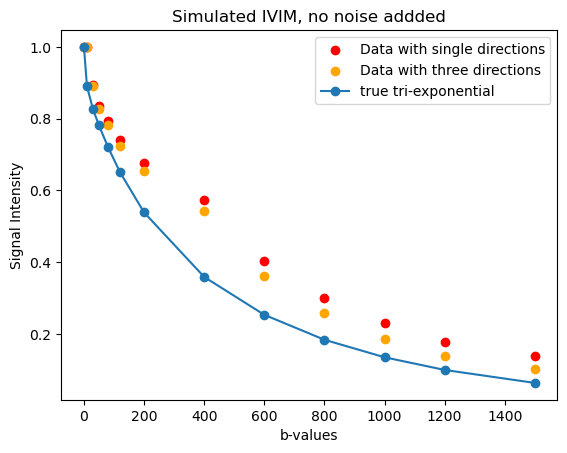

In [13]:
pl.scatter(b_values,SI_est,color = 'red', label = 'Data with single directions')
pl.scatter(b_values,SI_est_av,color = 'orange', label = 'Data with three directions')


pl.plot(b_values,SI,label = 'true tri-exponential', marker = 'o')
pl.title('Simulated IVIM, no noise addded')
pl.xlabel('b-values')
pl.ylabel('Signal Intensity')
pl.legend()
pl.show()


In [14]:
# now add noise
SI_est_noise = NoiseRice(SI_est, .02) # with SNR = 50

SI_est_noise_av = NoiseRice(SI_est_av, .02) # with SNR = 50

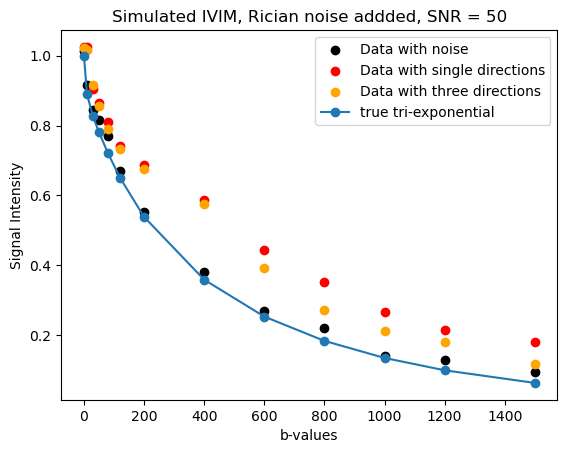

In [15]:
pl.scatter(b_values,SI_noise,color = 'black', label = 'Data with noise')
pl.scatter(b_values,SI_est_noise,color = 'red', label = 'Data with single directions')
pl.scatter(b_values,SI_est_noise_av,color = 'orange', label = 'Data with three directions')


pl.plot(b_values,SI,label = 'true tri-exponential', marker = 'o')
pl.title('Simulated IVIM, Rician noise addded, SNR = 50')
pl.xlabel('b-values')
pl.ylabel('Signal Intensity')
pl.legend()
pl.show()


# Now need to fit it and see how much worse it is compared to truth.

# just export it as an excel file and then fit it... 


Use matlab multi-exp?

https://www.mathworks.com/help/matlab/matlab_external/call-user-script-and-function-from-python.html

# and try if 2 directions rather than 1 direction also improves it


Maintaining 10 b-values while increasing the range to b=0– 1,100 s/mm2 improved the AUC to 0.83. Using a medium b-value range of b=0–1,380 s/mm2 (with 15 b-values) improved the AUC to >0.90,